In [ ]:
import cv2
import numpy as np

# Read image
img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/IMG_3490.jpg")

# Convert to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# rgb_planes = cv2.split(img)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)


In [ ]:
# result,type(result)

In [2]:
import pandas as pd
import numpy as np

# read data

df = pd.read_csv("/home/jiaenliu/final_project/saved.csv")

df.head()

,id,correct,date,naive_date_confidence,total,naive_total_confidence,text
0,4,True,2017-02-27 12:29:14,0.687667,6.74,0.667967,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
1,5,True,2017-02-26 11:10:32,0.689433,11.16,0.667933,city\nCRF-CITY LA ROCHELLE\n33 RUE DE LA SCIER...
2,6,True,2017-02-25 11:05:35,0.704167,6.99,0.668133,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
3,9,True,2016-05-23 12:29:03,0.697633,5.04,0.668100,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
4,10,True,2016-04-22 20:25:13,0.685633,14.46,0.667833,Carrefour\ncity\nCRF-CITY LA ROCHELLE\n33 RUE ...


In [3]:
true_df = df[df['correct'] == True]
true_df.head()

,id,correct,date,naive_date_confidence,total,naive_total_confidence,text
0,4,True,2017-02-27 12:29:14,0.687667,6.74,0.667967,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
1,5,True,2017-02-26 11:10:32,0.689433,11.16,0.667933,city\nCRF-CITY LA ROCHELLE\n33 RUE DE LA SCIER...
2,6,True,2017-02-25 11:05:35,0.704167,6.99,0.668133,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
3,9,True,2016-05-23 12:29:03,0.697633,5.04,0.668100,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
4,10,True,2016-04-22 20:25:13,0.685633,14.46,0.667833,Carrefour\ncity\nCRF-CITY LA ROCHELLE\n33 RUE ...


In [4]:
true_df.to_csv("/home/jiaenliu/final_project/train.csv")

In [34]:
false_df = df[df['correct'] == False]
false_df.head()

,id,correct,date,naive_date_confidence,total,naive_total_confidence,text
32,73,False,2016-01-20 19:11:51,0.693567,0.10,0.334600,Carrefour city\nCRF-CITY LA ROCHELLE\n33 RUE D...
56,146,False,2016-11-17 13:12:23,0.685333,3.11,0.668300,Carrefour\ncity\nCRF-CITY LA ROCHELLE\n33 RUE ...
66,168,False,2017-01-13 13:48:44,0.693800,12.41,0.334933,﻿city\nCRF-CITY LA ROCHELLE\n33 RUE DE LA SCIE...
97,248,False,2016-12-18 12:17:39,0.685467,27.49,0.667567,Carrefour\nmarket\nCarrefour market AYTRE\nTel...
99,257,False,2016-06-11 13:54:04,0.675800,156.00,0.667633,﻿Carrefour\nmarke t\nCarrefour market AYTRE\nT...


In [36]:
false_df.to_csv("/Users/liujiaen/Documents/Text_Recognition/final_project/false.csv", index=False)

In [ ]:
true_df.drop(['correct','naive_date_confidence','naive_total_confidence','text'], axis=1, inplace=True)
true_df.head()

In [ ]:
true_df.shape

## Now let us use layoutLMv2 to extract date and amount from the invoice

In [25]:
import os
import cv2
import uuid
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast
from datasets import load_dataset
# from torchvision.datasets.utils import download_file_from_google_drive

In [11]:
dataset = load_dataset("nielsr/cord-layoutlmv3", split="test")

Found cached dataset cord-layoutlmv3 (/home/jiaenliu/.cache/huggingface/datasets/nielsr___cord-layoutlmv3/cord/1.0.0/581083d58bb5c35fdcfed4f7b36f9a8bf23acfd28e974edc7b8157c972720203)


In [12]:
dataset

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
    num_rows: 100
})

In [14]:
labels = dataset.features['ner_tags'].feature.names
print(labels)

['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.CNT', 'I-MENU.DISCOUNTPRICE', 'I-MENU.PRICE', 'I-MENU.ITEMSUBTOTAL', 'I-MENU.VATYN', 'I-MENU.ETC', 'I-MENU.SUB_NM', 'I-MENU.SUB_UNITPRICE', 'I-MENU.SUB_CNT', 'I-MENU.SUB_PRICE', 'I-MENU.SUB_ETC', 'I-VOID_MENU.NM', 'I-VOID_MENU.PRICE', 'I-SUB_TOTAL.SUBTOTAL_PRICE', 'I-SUB_TOTAL.DISCOUNT_PRICE', 'I-SUB

In [ ]:
#  create a label to color mapping
labels = dataset.features['ner_tags'].feature.names
label2color = {label: np.random.randint(0, 255, 3).tolist() for label in labels}


In [5]:
labels[1:-1]

['B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL']

In [38]:
def get_layoutlmv2(ocr_lang = "fra"):
    feature_extractor = LayoutLMv3FeatureExtractor(ocr_lang=ocr_lang,tesseract_config="--psm 12 --oem 2")
    tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
    # processor = LayoutLMv2Processor(feature_extractor, tokenizer)
    model = LayoutLMv3ForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-cord")
    return tokenizer, feature_extractor, model

def get_labels():
    # dataset = load_dataset("darentang/sroie", split="test")
    # define id2label, label2color
    labels = ['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.CNT', 'I-MENU.DISCOUNTPRICE', 'I-MENU.PRICE', 'I-MENU.ITEMSUBTOTAL', 'I-MENU.VATYN', 'I-MENU.ETC', 'I-MENU.SUB_NM', 'I-MENU.SUB_UNITPRICE', 'I-MENU.SUB_CNT', 'I-MENU.SUB_PRICE', 'I-MENU.SUB_ETC', 'I-VOID_MENU.NM', 'I-VOID_MENU.PRICE', 'I-SUB_TOTAL.SUBTOTAL_PRICE', 'I-SUB_TOTAL.DISCOUNT_PRICE', 'I-SUB_TOTAL.SERVICE_PRICE', 'I-SUB_TOTAL.OTHERSVC_PRICE', 'I-SUB_TOTAL.TAX_PRICE', 'I-SUB_TOTAL.ETC', 'I-TOTAL.TOTAL_PRICE', 'I-TOTAL.TOTAL_ETC', 'I-TOTAL.CASHPRICE', 'I-TOTAL.CHANGEPRICE', 'I-TOTAL.CREDITCARDPRICE', 'I-TOTAL.EMONEYPRICE', 'I-TOTAL.MENUTYPE_CNT', 'I-TOTAL.MENUQTY_CNT']
    id2label = {v: k for v, k in enumerate(labels)}
    label2color = {label: tuple(np.random.randint(0, 255, 3).tolist()) for label in labels}
    label2color = dict((k.lower(), v) for k,v in label2color.items())
    return id2label, label2color

# Unnormalize the bounding box coordinates.
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

# iob to label
def iob_to_label(label):
    return label

In [39]:
def process_image(image, feature_extractor, tokenizer, model, id2label, label2color):
    """
    Process the image and return predictions.

    Args:
        image (PIL.Image): Image to be processed.
        # processor (LayoutLMv2Processor): LayoutLMv2 processor.
        feature_extractor (LayoutLMv2FeatureExtractor): LayoutLMv2 feature extractor.
        tokenizer (LayoutLMv2TokenizerFast): LayoutLMv2 tokenizer.
        model (LayoutLMv2ForTokenClassification): LayoutLMv2 model.
        id2label (dict): Dictionary mapping label id to label name.
        label2color (dict): Dictionary mapping label name to color.
    Returns:
        PIL.Image: Image with predictions drawn on it.
    """
    if not os.path.exists("error_images"):
        os.mkdir("error_images")
    
    files = os.listdir("error_images")
    if len(files) > 20:
        # remove the first file
        os.remove("error_images/" + files[0])

    width, height = image.size

    # encode the image, get the bounding boxes and the words
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    # print(encoding_feature_extractor.keys())
    # print(encoding_feature_extractor.words)
    words, boxes = encoding_feature_extractor.words[0], encoding_feature_extractor.boxes[0]
    # print(words)
    text = " ".join(words)
    encoding = tokenizer(words, boxes=boxes, return_offsets_mapping=True, return_tensors="pt", truncation=True)
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    # encoding["image"] = encoding_feature_extractor.pixel_values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for k, v in encoding.items():
        encoding[k] = v.to(device)

    model.to(device)

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # TODO:Read the paper and understand the offset_mapping
    # Keep length of words, predictions and boxes equal

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    # print(is_subword)
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    true_predictions = true_predictions[1:-1]
    true_boxes = true_boxes[1:-1]
    
    print(len(words),len(true_predictions),len(true_boxes))
    # if length of words, predictions and boxes are not equal, then save the image
    if len(words) != len(true_predictions) or len(words) != len(true_boxes):
        image.save("error_images/" +str(uuid.uuid4()) + ".jpg")
        print("There is an error when processing the image. Please check the error_images folder.")

    print(words)
    print(true_predictions)


    # json_df = []
    preds = []
    l_words = []
    bbox = []

    for i,j in enumerate(true_predictions):
        if j != 'O':
            preds.append(j)
            l_words.append(words[i])
            bbox.append(true_boxes[i])

    # draw = ImageDraw.Draw(image)
    # font = ImageFont.load_default()
    # # print(zip(true_predictions, true_boxes))
    # for ix, (prediction, box) in enumerate(zip(true_predictions, true_boxes)):
    #     predicted_label = iob_to_label(prediction).lower()
    #     draw.rectangle(box, outline=label2color[predicted_label])
    #     draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

    # get the text from the labeled box 
    # print(text)
    return image, text, bbox, preds, l_words


In [40]:
def visualize_image(final_bbox, final_preds, l_words, image, label2color, ):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    # l2l = {'question':'key', 'answer':'value', 'header':'title'}
    # f_labels = {'question':'key', 'answer':'value', 'header':'title', 'other':'others'}

    json_df = []

    for ix, (prediction, box) in enumerate(zip(final_preds, final_bbox)):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

        json_dict = {}
        json_dict['TEXT'] = l_words[ix]
        json_dict['LABEL'] = predicted_label
        
        json_df.append(json_dict)

    return image, json_df

In [44]:
from itertools import groupby

In [45]:
def process_form(json_df):
    labels = [x['LABEL'] for x in json_df]
    texts = [x['TEXT'] for x in json_df]
    cmb_list = []
    for i, j in enumerate(labels):
        cmb_list.append([labels[i], texts[i]])
        
    grouper = lambda l: [[k] + sum((v[1::] for v in vs), []) for k, vs in groupby(l, lambda x: x[0])]
    
    list_final = grouper(cmb_list)
    lst_final = []
    for x in list_final:
        json_dict = {}
        json_dict[x[0]] = (' ').join(x[1:])
        lst_final.append(json_dict)
    
    return lst_final

In [42]:
tokenizer, feature_extractor, layoutLMv2 = get_layoutlmv2()
id2label, label2color = get_labels()

In [51]:
image = Image.open("/home/jiaenliu/final_project/testimage/4.jpg")

# resize the image
image = image.resize((600, 1200))
image, text, bbox, preds, l_words = process_image(image, feature_extractor, tokenizer, layoutLMv2, id2label, label2color)

image, json_df = visualize_image(bbox, preds, l_words, image, label2color)
json_df = process_form(json_df)

print(json_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jiaenliu/miniconda3/envs/receipt/lib/python3.8/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


95 96 96
There is an error when processing the image. Please check the error_images folder.
['<#', 'c1ty', 'CRF-CITY', 'LA', 'ROCHELLE', '33', 'RUE', 'DE', 'LA', 'SCIERIE', '17000', 'LA', 'ROCHELLE', 'Tel', '05.46.27.02,12', 'DESCRIPT', 'ION', 'QTE', 'HONTANT', 'x85G', 'VERRINE', 'TIRAHI', '2.01€', '*PARMENTIER', 'CANARD', '4.73€', 'cerèssess', 'G', '=', 'éF', 'se', 'esRe=', '==', '2', 'ARTICLE', '(b)', 'e', 'q', 'TOTAL', 'À', 'PAYER', '6.74€', 'Coéémemes', 'e', 'es', 'Es', 'CB', 'EMV', 'SAN', 'ONTACT', 'EUR', '6.74€', 'Si', 'vous', 'aviez', 'la', 'carte', 'fidélité', 'vous', 'auriez', 'cumulé', '0.30€', 'sur', 'votre', 'compte', 'fidélité', 'Carrefour', 'p', '-', 'Détails:', '..', '—m4208', 'dpi', 'A', '10', 'É', 'LUE', '453', 'Remise', 'produwtæ', 'fide', '0.30€', '0006', '00.', '4', '4', '000122', '27/02/2017', '12:24:45', 'MERCI', 'DE', 'VOTRE', 'VISITE', 'A', 'BIENTOT']
['I-MENU.DISCOUNTPRICE', 'I-MENU.DISCOUNTPRICE', 'I-MENU.NM', 'B-MENU.NM', 'I-MENU.SUB_NM', 'B-MENU.NUM', 'I-MEN

IndexError: list index out of range

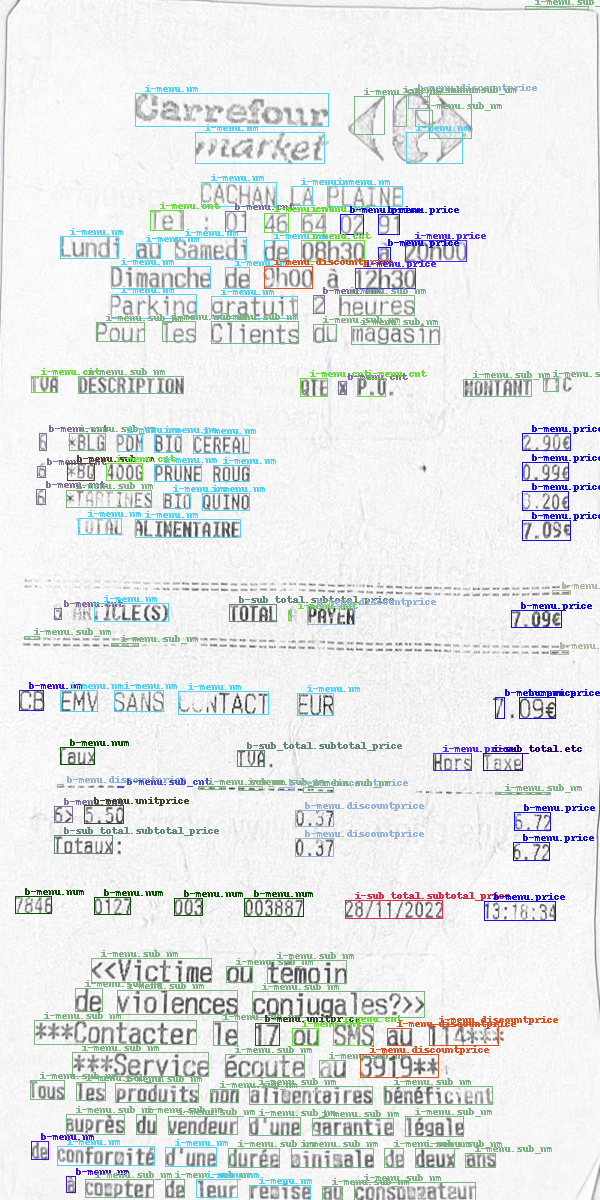

In [48]:
display(image)

In [49]:
# save the image
image.save("test" + ".jpg")

In [50]:
import pytesseract
from PIL import Image
# /Users/liujiaen/Documents/Text_Recognition/final_project/error_images/2a23868c-23e3-4638-beac-4db7fe220634.jpg
image = Image.open("/home/jiaenliu/final_project/testimage/4.jpg")
data = pytesseract.image_to_data(image, config='--psm 12 --oem 2')
print(data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TesseractError: (1, "Error: Tesseract (legacy) engine requested, but components are not present in /usr/share/tesseract-ocr/5/tessdata/eng.traineddata!! Failed loading language 'eng' Tesseract couldn't load any languages! Could not initialize tesseract.")

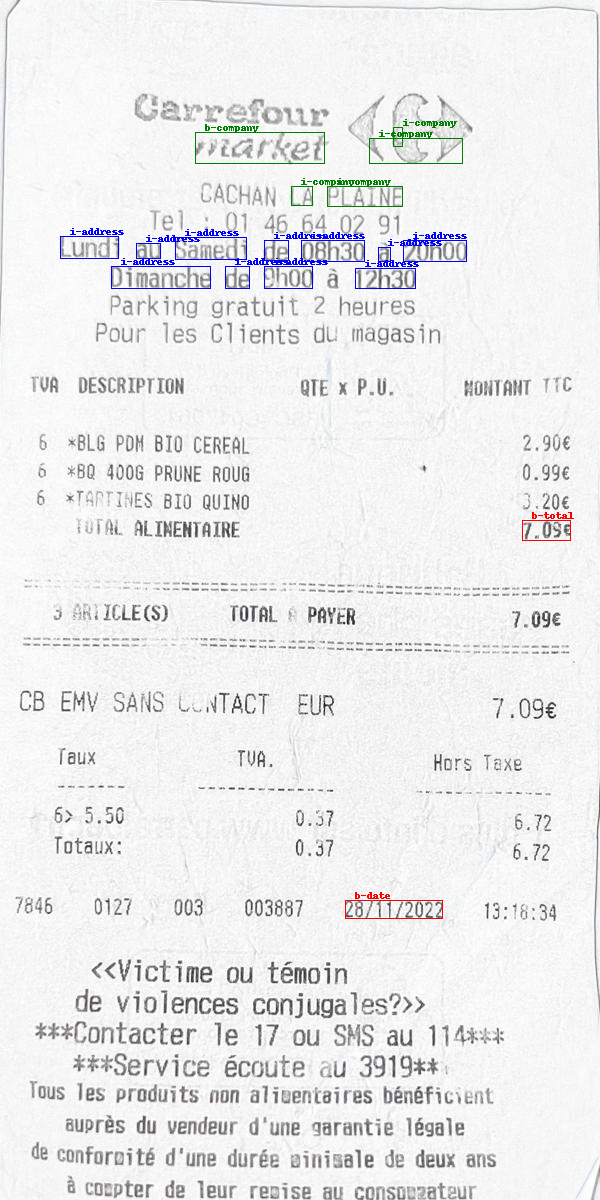

In [48]:
image

In [24]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
print(is_subword)
print(len(is_subword))

[False False False  True  True False False False  True  True False  True
 False  True False False  True  True  True  True  True  True  True  True
 False False  True  True False False  True  True False False  True  True
 False False  True  True False False  True  True False  True False False
  True False  True False False False False  True  True  True  True False
  True  True False False  True  True  True False  True  True False False
 False  True  True False  True  True False  True False False  True False
  True False  True  True False  True  True False False  True  True  True
 False  True False False  True False  True False  True False False False
  True  True False False  True  True False  True  True False  True  True
 False False False  True False  True  True False  True  True False  True
  True False  True False False  True  True False False  True False  True
  True False False  True False  True False  True  True  True  True  True
 False  True False False  True  True  True  True Fa

In [22]:
np.array(offset_mapping.squeeze().tolist())[0:]

array([[0, 0],
       [0, 5],
       [0, 1],
       [1, 2],
       [2, 3]])

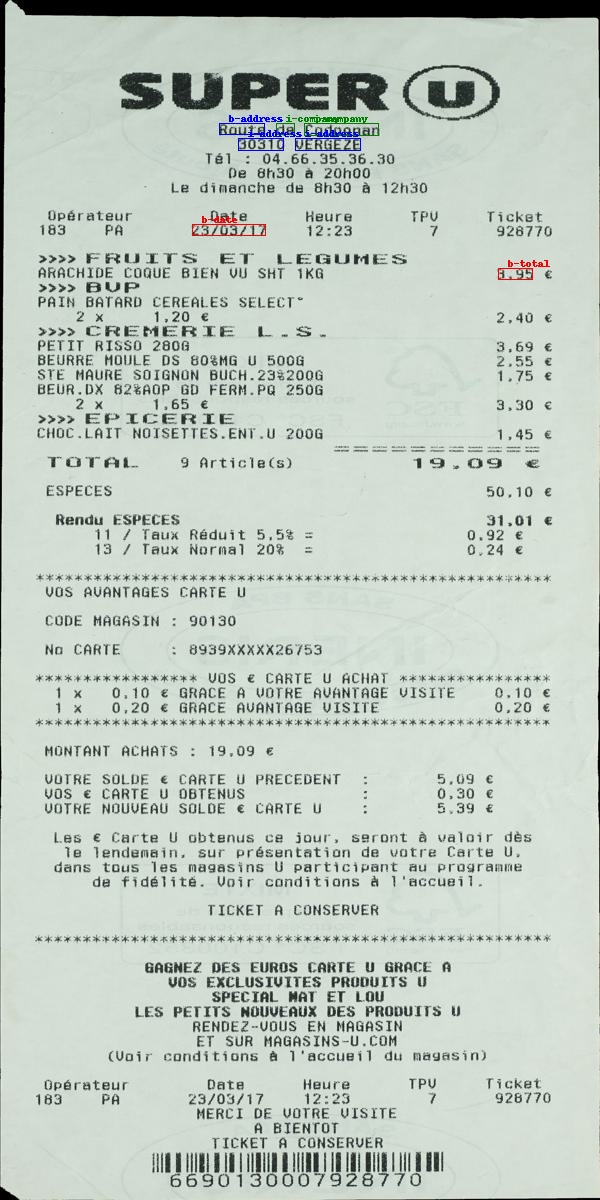

In [45]:
image

In [43]:
text

'PRIMEURS 17 06 63 28 50 44 Balance : 3 Client : 31 Date 10/06/2017 11 : 45 VYendeur : 4 DELPHINE Rayon 1 » Num Ticket 197 Kg € ”/ K9 abricot 1, 045 3, 90 4, 08 avocat l 2n ATt 7 1 50 3, 00 TOTAL: à ,08 Dont TVA 5,50 %: 0: 31 € Potal ” TVA 0,97 Total HT 6 ,. 71 2 transaction(s) 3 Article(+) Ë.-un.Auusnuunn.nﬂih-.—u;—..….- À à à à à'

In [40]:
json_df

[{'TEXT': '10/06/2017', 'LABEL': 'b-date'}]

In [12]:
import re

In [28]:
date = []
total = ""
for i in range(len(json_df)):
    if "date" in json_df[i]["LABEL"] :
        # date = json_df[i]["TEXT"]
        date.append(json_df[i]["TEXT"])
        print(json_df[i]["TEXT"])
    elif "total" in json_df[i]["LABEL"]:
        total = re.sub(r'[^\d.]', '', json_df[i]["TEXT"])
        print(float(total))

5.04
23/05/2016


In [ ]:
# resive the image

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/test_scripts/985.jpg")

# resize the image
img = cv2.resize(img, 600, )

In [26]:
" ".join(date)

'23/05/2016'

In [41]:
from dateutil.parser import parse
test = parse(" ".join(date), fuzzy=True)

In [42]:
test.date()

datetime.date(2016, 5, 23)

In [32]:
import datetime

test.date() == datetime.datetime.strptime(" ".join(date), '%d/%m/%Y').date()

True

In [ ]:
IMG_PATH = "/Users/liujiaen/Documents/Text_Recognition/dataset/findit/FindIt-Dataset-Train/T1-train/img"



In [ ]:
true_prediction

In [45]:
text

'PRIMEURS 17 06 63 28 50 44 Balance : 3 Client : 31 Date 10/06/2017 11 : 45 VYendeur : 4 DELPHINE Rayon 1 » Num Ticket 197 Kg € ”/ K9 abricot 1, 045 3, 90 4, 08 avocat l 2n ATt 7 1 50 3, 00 TOTAL: à ,08 Dont TVA 5,50 %: 0: 31 € Potal ” TVA 0,97 Total HT 6 ,. 71 2 transaction(s) 3 Article(+) Ë.-un.Auusnuunn.nﬂih-.—u;—..….- À à à à à'

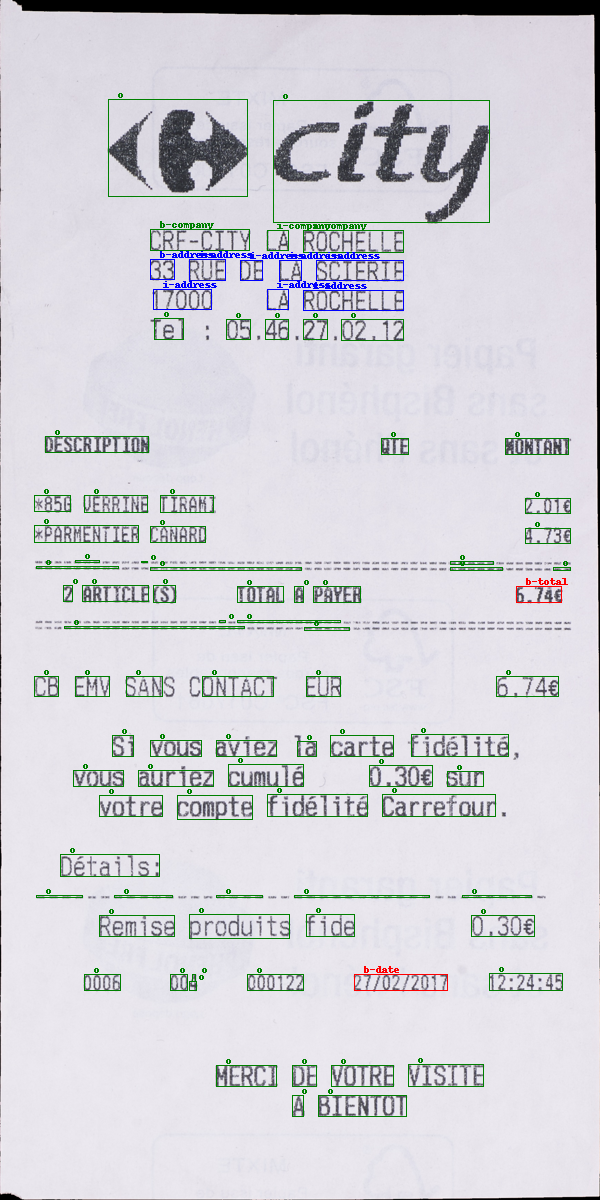

In [8]:
image

In [5]:
import easyocr

reader = easyocr.Reader(['en',"fr"], gpu=False)
result = reader.readtext('/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/66.jpg',detail=0)
result

Using CPU. Note: This module is much faster with a GPU.


['Carrefour',
 '1',
 'CRF-CITY LA ROCHELLE',
 '33 RUE DE LA SCIERIE',
 '17000',
 'LA ROCHELLE',
 'Te]',
 '05.46.27 .02, 12',
 'DESCRIPTION',
 'QTE',
 'NoNTANt',
 '30H ALUMINIUNxxxxx',
 '1.43€',
 'BANANE',
 '1.24€',
 '0.6350kg X',
 '1.956/k9',
 'CHAHPI PIED HCX CR',
 '0.756',
 'CREME LAVANTe PECH',
 '0.81€',
 'EcosaC CABAS CRF AGI',
 '2.80€',
 'EHHEHTAL RAPE 1006',
 '0.97€',
 'FARINE BLE T45',
 '',
 '0.6o€',
 'LASAGNE BARILLA',
 '',
 '2.12€',
 'HANDARihe',
 '2.35€',
 '0.7950k9 x',
 '2.956/kg',
 'OLIVE HRE GRECQUE',
 '1.28€',
 'PAIN HIE HOELL.CRF',
 '0.52€',
 'PATE BRISEE ETALEE',
 '0.756',
 'PDT GRosse KG',
 '0.97e',
 '0.6450k9',
 'X',
 '1.506/kg',
 'PET 1.5L EAU HIN',
 '2x',
 '0.58',
 '1.16€',
 'RAVIoLI 4FROHAGES',
 '1.71€',
 '16 ARTICLE(S)',
 'ToTAL',
 'R PAYER',
 '19',
 'ESPECES',
 'EUR',
 '20.Oo€',
 'Votre Monnaie',
 '-0.54€',
 '0007',
 '004',
 '000315',
 '12/01/2016',
 '17:42:38',
 '',
 'MERCI DE VOTRE VISITE',
 'A BIENTOT',
 'city']

In [6]:
" ".join(result)

'Carrefour 1 CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 17000 LA ROCHELLE Te] 05.46.27 .02, 12 DESCRIPTION QTE NoNTANt 30H ALUMINIUNxxxxx 1.43€ BANANE 1.24€ 0.6350kg X 1.956/k9 CHAHPI PIED HCX CR 0.756 CREME LAVANTe PECH 0.81€ EcosaC CABAS CRF AGI 2.80€ EHHEHTAL RAPE 1006 0.97€ FARINE BLE T45  0.6o€ LASAGNE BARILLA  2.12€ HANDARihe 2.35€ 0.7950k9 x 2.956/kg OLIVE HRE GRECQUE 1.28€ PAIN HIE HOELL.CRF 0.52€ PATE BRISEE ETALEE 0.756 PDT GRosse KG 0.97e 0.6450k9 X 1.506/kg PET 1.5L EAU HIN 2x 0.58 1.16€ RAVIoLI 4FROHAGES 1.71€ 16 ARTICLE(S) ToTAL R PAYER 19 ESPECES EUR 20.Oo€ Votre Monnaie -0.54€ 0007 004 000315 12/01/2016 17:42:38  MERCI DE VOTRE VISITE A BIENTOT city'